In [12]:
import pickle
import glob
import re
import os
import copy
import subprocess
import time
from datetime import datetime, timedelta, date
from collections import defaultdict, Counter, OrderedDict
from functools import reduce

import vcf
import pysam
import numpy as np
import pandas as pd
import dask.dataframe as dd
from Bio import SeqIO
from Bio.SeqUtils import seq1
from Bio.Seq import Seq

import random

from utils.file_loaders import load_metadata, load_vdb_mutation_data, merge_data, load_vdb_df, load_alias_data
from utils.quaid_func import get_counts, get_all_voc, build_count_df, get_recent_nt_df

In [13]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [14]:
def check_dataframe_status(df):
    print(f"Shape: {df.shape}")
    print(f"Features: {list(df.columns.values)}")

In [15]:
def mutation_comb_msa_query(test_set, output_acc_id=False):
    possible_voc_sets = []
    for mutation in test_set:
        try:
            possible_voc_sets.append(sublineage_mutations_exist_lookup[mutation])
        except KeyError:
            possible_voc_sets.append(set())
    lineage_date_combs = set.intersection(*possible_voc_sets)
    
    mutation_prevalence_dict = defaultdict(int)
    for lineage_date_comb in lineage_date_combs:
        lineage, _ = lineage_date_comb.split("/")
        try:
            for acc_id in genome2snp_dict[lineage_date_comb]:
                if test_set.issubset(genome2snp_dict[lineage_date_comb][acc_id]):
                    if output_acc_id:
                        print(acc_id)
                    mutation_prevalence_dict[lineage] += 1
        except KeyError:
            continue
    return mutation_prevalence_dict

# Load prebuild database and metadata

In [16]:
"""
if databases have been build, then set prebuild=True to load them directly
the lastest version of the database is built with max_date="2022-05-09"
"""
prebuild = True
max_date = "2022-10-21"

In [17]:
metadata_f = "/home/Users/ns58/SARS-CoV-2-MSA-10-21-2022/metadata.tsv"
vdb_df_path = "/home/Users/ns58/WW/vdb_output/vdb_lineage_df_week.csv"
trimmed_vdb_f = "/home/Users/ns58/SARS-CoV-2-MSA-10-21-2022/vdb_10212022_trimmed_nucl.txt"

## Load metadata

In [18]:
def load_metadata(path):
    #logger.info(f'Loading {path}')
    _metadata = pd.read_csv(path, sep='\t', low_memory=False)
    _metadata = _metadata[(_metadata['Is complete?'] == True) & (_metadata['Host'] == 'Human')]
    _metadata = _metadata[['Pango lineage', 'Collection date', 'Accession ID', 'Location']].copy()
    _metadata = _metadata[_metadata['Collection date'].str.len() == 10].copy()
    _metadata['Collection date'] = pd.to_datetime(_metadata['Collection date'])
    _metadata = _metadata[_metadata['Pango lineage'].notna()].copy()
    _metadata = _metadata.set_index(['Collection date'])
    return _metadata

In [19]:
%%time
metadata = load_metadata(metadata_f)

CPU times: user 2min 23s, sys: 25.9 s, total: 2min 49s
Wall time: 2min 49s


In [20]:
genome_counts = get_counts(metadata)
metadata.reset_index(inplace=True)
metadata.set_index("Accession ID", inplace=True)

In [21]:
total_genome_counts = genome_counts.reset_index().drop("Collection date", axis=1).rename({"Accession ID": "Count"}, axis=1).groupby("Pango lineage").sum()

## Prebuild SNP Dataframe

In [22]:
output = 'output_incl_recombinant'
dbs = 'quarc_dbs_01102023_incl_recombinant'

In [23]:
%%time
#sublineage_prevalence_f=f'/home/Users/yl181/wastewater/archived/quaid/output/prevalence-rate-2022-05-09.tsv'
#sublineage_prevalence_f = 'quarc_output/prevalence_date_df.csv'
if not prebuild:
    sublineage_mutations_lookup = get_sublineage_mutations(prevalence_rate_table, min_prevalence=0.5)
    # create a binary pickle file 
    f = open(f"{output}/mutation50_lookup.pkl","wb")
    # write the python object (dict) to pickle file
    pickle.dump(sublineage_mutations_lookup, f)
    # close file
    f.close()
else:
    file_to_read = open(f"{dbs}/mutation50_lookup.pkl", "rb")
    sublineage_mutations_lookup = pickle.load(file_to_read)

CPU times: user 379 ms, sys: 3.73 ms, total: 382 ms
Wall time: 439 ms


In [24]:
%%time
if not prebuild:
    sublineage_mutations_exist_lookup = get_sublineage_mutations(prevalence_rate_table, min_prevalence=0)
    # create a binary pickle file 
    f = open(f"{output}/mutation0_lookup.pkl","wb")
    # write the python object (dict) to pickle file
    pickle.dump(sublineage_mutations_exist_lookup, f)
    # close file
    f.close()
else:
    file_to_read = open(f"{dbs}/mutation0_lookup.pkl", "rb")
    sublineage_mutations_exist_lookup = pickle.load(file_to_read)

CPU times: user 4.52 s, sys: 268 ms, total: 4.79 s
Wall time: 4.83 s


In [25]:
%%time
#prebuild = False

if prebuild:
    file_to_read = open(f"{dbs}/quarc_db.pkl", "rb")
    genome2snp_dict = pickle.load(file_to_read)
else:
    mutations_data = load_vdb_mutation_data(trimmed_vdb_f)
    mutations_data.drop(["Date", "Region"], axis=1, inplace=True)
    merged_data = merge_data(mutations_data, metadata)
    merged_data.set_index("Accession ID", inplace=True)
    genome2snp_dict = build_genome2snp_database(merged_data)

CPU times: user 8min 5s, sys: 1min 33s, total: 9min 38s
Wall time: 9min 38s


In [26]:
gisaid_total_count = len(metadata)
gisaid_total_count

12988494

In [27]:
gisaid_total_count = 12988494

# Load Result

In [28]:
merged_df = pd.read_csv(os.path.join(output, 'merged_df.csv'))

In [29]:
merged_df = merged_df[(merged_df['Site'] != 'NTC') & (merged_df['Site'] != 'PTC')]

In [30]:
merged_df['Date'] = merged_df['Date'].apply(str)
merged_df['Date'] = merged_df['Date'].apply(lambda x: x.zfill(8))
merged_df['Date'] = merged_df['Date'].apply(lambda x: f'{x[0:2]}/{x[2:4]}/{x[4:]}')

In [31]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [32]:
exclude_sites = [187, 1059, 2094, 3037, 3130, 6990, 8022, 10323, 10741, 11074, 13408,
                 14786, 19684, 20148, 21137, 24034, 24378, 25563, 26144, 26461, 26681, 28077, 28826, 28854, 29700]

In [33]:
exclude_sites = exclude_sites + list(np.arange(1,56)) + list(np.arange(29804, 29904))

In [34]:
len(exclude_sites)

180

In [35]:
keep_records = []
for idx, row in merged_df.iterrows():
    nt_mutations = row['Nt Mutations'].split(";")
    keep = True
    for mut in nt_mutations:
        pos = int(mut[1:-1])
        if pos in exclude_sites:
            keep = False
            break
            
    if keep:
        keep_records.append(row)

In [36]:
merged_df = pd.DataFrame(keep_records)

In [37]:
len(merged_df['Nt Mutations'].unique())

6818

In [38]:
merged_df

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq
0,2022-01-06,203,A13098G;T13195C,ORF1a:K4278R;ORF1a:V4310V,8,119,0.067227
1,2022-01-06,203,T23599G;C23604A;G23642T,S:N679K;S:P681H;S:A694S,5,30,0.166667
2,2022-01-06,69,A24966T;C25000T,S:N1135I;S:D1146D,5,56,0.089286
3,2022-01-06,69,A29039T;G29049A,N:K256*;N:R259Q,8,380,0.021053
4,2022-01-06,76,G28881A;G28882A;G28883C;G28931T,N:R203K;N:R203R;N:G204R;N:A220S,5,99,0.050505
...,...,...,...,...,...,...,...
11474,2021-12-30,WD,C15805A;A15812T,ORF1b:Q780K;ORF1b:N782I,17,553,0.030741
11475,2021-12-30,WD,C24130A;A24250G,S:N856K;S:I896M,8,107,0.074766
11476,2021-12-30,WD,A24966T;C25000T,S:N1135I;S:D1146D,45,1547,0.029089
11477,2021-12-30,WD,G28881A;G28882A;G28883C;A29039T,N:R203K;N:R203R;N:G204R;N:K256*,14,324,0.043210


In [39]:
#merged_df.to_csv('../quarc_figures/merged_df.csv')

## Load from Filtered Results

In [40]:
merged_df = pd.read_csv('../quarc_figures/merged_df.csv', index_col=0)
merged_df['Date'] = merged_df['Date'].apply(str)
merged_df['Date'] = pd.to_datetime(merged_df['Date'], format='%Y-%m-%d')

In [41]:
file_to_read = open(os.path.join(output, "query_result.pkl"), "rb")
query_result = pickle.load(file_to_read)

In [42]:
count_rarity_dict = dict()
for key in query_result:
    count_rarity_dict[key] = sum(query_result[key].values())
gisaid_count_df = pd.DataFrame.from_dict(count_rarity_dict, columns=['GISAID Count'], orient='index')

site_count_df = pd.DataFrame(merged_df.groupby('Nt Mutations')['Site'].count())
mutation_rarity_df = site_count_df.merge(gisaid_count_df, left_index=True, right_index=True, validate='one_to_one')

# Perfomance Measure

In [412]:
# bar plot bins
gisaid_count_range = [0, 5, 10, 25, 50, 100, 250, 500]

hist_bars = []
labels = []
for idx, upper_range in enumerate(gisaid_count_range):
    lower_range = gisaid_count_range[idx-1]
    if lower_range > upper_range:
        lower_range = -1
        labels.append(f"0")
    else:
        labels.append(f"{lower_range+1}-{upper_range}")
    hist_bars.append(len(mutation_rarity_df[(mutation_rarity_df['GISAID Count'] > lower_range)&(mutation_rarity_df['GISAID Count'] <= upper_range)]))
hist_bars.append(len(mutation_rarity_df[(mutation_rarity_df['GISAID Count'] > gisaid_count_range[-1])]))
labels.append(f"> {gisaid_count_range[-1]}")

In [413]:
# # bar plot bins
# gisaid_count_range = [0, 5, 10, 25, 50, 100, 250, 500, 1000, 2000]

# hist_bars = []
# labels = []
# for idx, upper_range in enumerate(gisaid_count_range):
#     lower_range = gisaid_count_range[idx-1]
#     if lower_range > upper_range:
#         lower_range = -1
#         labels.append(f"0")
#     else:
#         labels.append(f"{lower_range+1}-{upper_range}")
#     hist_bars.append(len(selected_data[(selected_data['GISAID Count'] > lower_range)&(selected_data['GISAID Count'] <= upper_range)]))
# hist_bars.append(len(selected_data[(selected_data['GISAID Count'] > gisaid_count_range[-1])]))
# labels.append(f"> {gisaid_count_range[-1]}")

In [414]:
# cumulative precentage
total_set_count = sum(hist_bars)

cum_precentages = []
for idx, item in enumerate(hist_bars):
    cum_precentages.append(sum(hist_bars[:idx+1])/total_set_count*100)

In [415]:
# query time test, random sampling, size=100 per bin
sampling_size = 50

if False:
    process_time = []

    for idx, upper_range in enumerate(gisaid_count_range):
        lower_range = gisaid_count_range[idx-1]
        if lower_range > upper_range:
            lower_range = -1

        selected_mutations = mutation_rarity_df[(mutation_rarity_df['GISAID Count'] > lower_range)&(mutation_rarity_df['GISAID Count'] <= upper_range)].index.to_list()
        random.shuffle(selected_mutations)

        process_time_bin = []
        for mutation_set in selected_mutations[0:sampling_size]:
            mutation_input = set(mutation_set.split(';'))
            time_start = time.process_time()
            _ = mutation_comb_msa_query(mutation_input)
            time_stop = time.process_time()
            process_time_bin.append(time_stop-time_start)

        print(lower_range, '-', upper_range, np.mean(process_time_bin))
        process_time.append(process_time_bin)
        
    selected_mutations = mutation_rarity_df[(mutation_rarity_df['GISAID Count'] > gisaid_count_range[-1])].index.to_list()
    random.shuffle(selected_mutations)

    process_time_bin = []
    for mutation_set in selected_mutations[0:sampling_size]:
        mutation_input = set(mutation_set.split(';'))
        time_start = time.process_time()
        _ = mutation_comb_msa_query(mutation_input)
        time_stop = time.process_time()
        process_time_bin.append(time_stop-time_start)

    print(f'> {gisaid_count_range[-1]}', np.mean(process_time_bin))
    process_time.append(process_time_bin)
    
    with open('/home/Users/yl181/wastewater/quarc_figures/performance_benchmark.txt', 'w') as performance_benchmark_f:
        for time_bin in process_time:
            performance_benchmark_f.write(",".join(map(str, time_bin)))
            performance_benchmark_f.write("\n")
            
else:
    with open('/home/Users/yl181/wastewater/quarc_figures/performance_benchmark.txt', 'r') as performance_benchmark_f:
        process_time = []
        for line in performance_benchmark_f.readlines():
            process_time_bin = [float(i) for i in line.strip().split(",")]
            process_time.append(process_time_bin)

In [416]:
mean_query_times = []
for time_bin in process_time:
    mean_query_times.append(np.mean(time_bin))

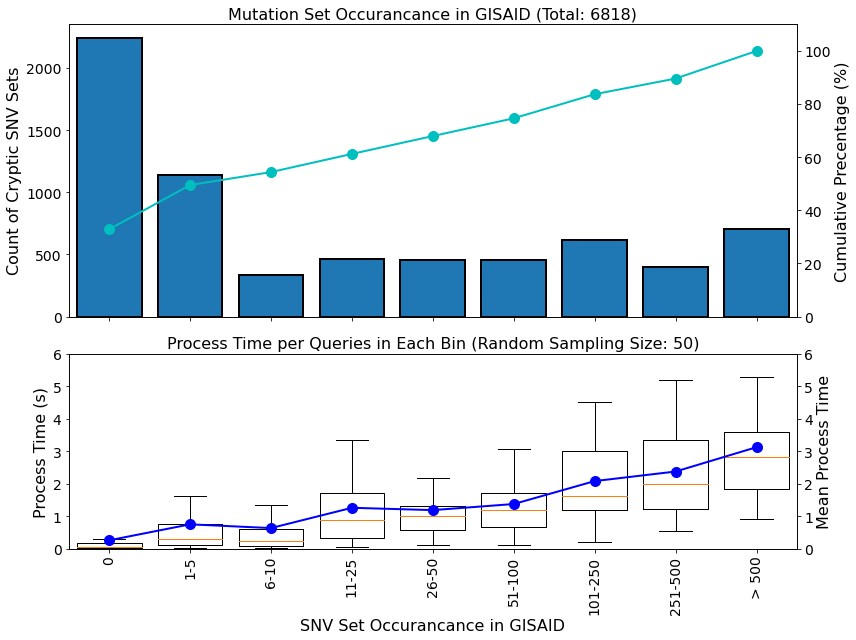

In [417]:
fontsize = 14
fig, axes  = plt.subplots(2, 1, figsize=(12, 9),
                          sharex=True,
                          gridspec_kw={'height_ratios': [3, 2]})

ax = axes[0]
ax.bar(np.arange(len(hist_bars)), hist_bars,
      linewidth = 2,
      edgecolor = 'black')

ax.set_xticks(np.arange(len(hist_bars)))
ax.set_xticklabels(labels, rotation=90)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('Count of Cryptic SNV Sets', fontsize=fontsize+2)
#ax.set_xlabel('SNV Set Occurancance in GISAID', fontsize=fontsize+2)
#ax.set_ylim(0,1800)

ax_twinx = ax.twinx()
ax_twinx.plot(np.arange(len(hist_bars)), cum_precentages, 
              'o-c',
              linewidth=2, markersize=10)
ax_twinx.tick_params(axis='both', which='major', labelsize=fontsize)
ax_twinx.set_ylabel('Cumulative Precentage (%)', fontsize=fontsize+2)
ax_twinx.set_ylim(0,110)

ax.set_title(f'Mutation Set Occurancance in GISAID (Total: {sum(hist_bars)})', fontsize=fontsize+2)

ax = axes[1]
bp = ax.boxplot(process_time,
                positions=np.arange(len(hist_bars)),
                showfliers=False,
                meanline=False,
                widths=0.8)

ax.set_xticks(np.arange(len(hist_bars)))
ax.set_xticklabels(labels, rotation=90)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('Process Time (s)', fontsize=fontsize+2)
ax.set_xlabel('SNV Set Occurancance in GISAID', fontsize=fontsize+2)
ax.set_title(f'Process Time per Queries in Each Bin (Random Sampling Size: {sampling_size})', fontsize=fontsize+2)
ax.set_ylim(0,6)

ax_twinx = ax.twinx()
ax_twinx.plot(np.arange(len(hist_bars)), mean_query_times, 
              'o-b',
              linewidth=2, markersize=10)
ax_twinx.tick_params(axis='both', which='major', labelsize=fontsize)
ax_twinx.set_ylabel('Mean Process Time', fontsize=fontsize+2)
ax_twinx.set_ylim(0,6)

fig.tight_layout()

# Mutation Distribution

In [43]:
gisaid_total_count = 12988494

In [44]:
mutation_rarity_df

,Site,GISAID Count
A10017T;C10029T;C23202A,1,0
A10021G;C10029T,1,293
A10021G;C10029T;T10135C,1,3
A1003G;C784T,1,0
A1003G;C913T,5,95
...,...,...
T9747C;A9748T,1,4
T9812C;T9813C,1,0
T9833C;C9891T,1,1
T9842C;C9891T,1,7


In [45]:
mutation_rarity_df.to_csv('../quarc_figures/mutation_rarity_df.csv')

In [46]:
min_site = 2
max_gisaid_occurance = 0.0001 * gisaid_total_count
print('max_gisaid_occurance:', max_gisaid_occurance)

selected_data = mutation_rarity_df[(mutation_rarity_df['Site'] >= min_site) & (mutation_rarity_df['GISAID Count'] <= max_gisaid_occurance)].copy()
selected_data = selected_data.rename({'Site': 'Mutation Occurance'}, axis=1)
len(selected_data)

max_gisaid_occurance: 1298.8494


716

In [47]:
present_weeks = []
present_sites = []
mean_freqs = []
max_freqs = []
max_durations = []
aa_mutations = []

for idx, row in selected_data.iterrows():
    mutation_df = merged_df[merged_df['Nt Mutations'] == idx]
    present_weeks.append(len(mutation_df['Date'].unique()))    
    present_sites.append(len(mutation_df['Site'].unique()))
    mean_freqs.append(mutation_df['Combined Freq'].mean())
    max_freqs.append(mutation_df['Combined Freq'].max())
    max_durations.append(int((mutation_df['Date'].unique().max()-mutation_df['Date'].unique().min()).astype('timedelta64[D]')/np.timedelta64(1, 'D') + 1))
    aa_mutations.append(mutation_df['AA Mutations'].unique()[0])

In [48]:
selected_data['AA_Mutation'] = aa_mutations
selected_data['Present Weeks'] = present_weeks
selected_data['Present Sites'] = present_sites
selected_data['Mean Site Occurance'] = selected_data['Mutation Occurance']/selected_data['Present Weeks']
selected_data['Mean Allele Freq'] = mean_freqs
selected_data['Max Allele Freq'] = max_freqs
selected_data['Max Durations'] = max_durations

In [49]:
selected_data_master = selected_data.sort_values(by=['Mutation Occurance', 'GISAID Count'], ascending=False).copy()
selected_data_master

,Mutation Occurance,GISAID Count,AA_Mutation,Present Weeks,Present Sites,Mean Site Occurance,Mean Allele Freq,Max Allele Freq,Max Durations
A29039T;G29049A,198,3,N:K256*;N:R259Q,33,37,6.000000,0.034385,0.142857,365
C6402T;G6456A,133,153,ORF1a:P2046L;ORF1a:C2064Y,19,38,7.000000,0.074002,0.750000,137
A24966T;C25000T,110,10,S:N1135I;S:D1146D,19,34,5.789474,0.047713,0.114754,316
G17122T;A17236G,99,346,ORF1b:A1219S;ORF1b:I1257V,19,34,5.210526,0.021824,0.069530,145
C14676T;G14857T,52,466,ORF1b:P403P;ORF1b:V464F,5,39,10.400000,0.205048,1.000000,57
...,...,...,...,...,...,...,...,...,...
T28382C;C28383A,2,0,N:S37P;N:S37*,1,2,2.000000,0.012149,0.014190,1
T28382C;C28383A;C28432T,2,0,N:S37P;N:S37*;N:F53F,1,2,2.000000,0.038820,0.044397,1
T28382C;C28419A;C28432T,2,0,N:S37P;N:T49N;N:F53F,1,2,2.000000,0.051540,0.060000,1
T689A;C690A;T692C;T693C;G881T,2,0,ORF1a:S142T;ORF1a:S142*;ORF1a:F143L;ORF1a:F143...,2,1,1.000000,0.484079,0.829268,8


In [50]:
week_count = sorted(selected_data['Present Weeks'].unique())
site_count_per_week = []
week_count_height = []

for week_idx in week_count:
    site_count_per_week.append(selected_data[selected_data['Present Weeks'] == week_idx]['Mean Site Occurance'].values)
    week_count_height.append(len(selected_data[selected_data['Present Weeks'] == week_idx]['Mean Site Occurance'].values))

In [51]:
selected_data_master[selected_data_master['Present Weeks'] <= 3].shape

(612, 9)

In [52]:
step = 100
occ_list = np.arange(0,14,1) * step
#occ_list = [0,200,400,600,800,1000,1200]
occ_bar_height = []
for occ_idx in occ_list:
    occ_bar_height.append(selected_data[(selected_data['GISAID Count'] >= occ_idx) & (selected_data['GISAID Count'] < occ_idx+step)].shape[0])
    

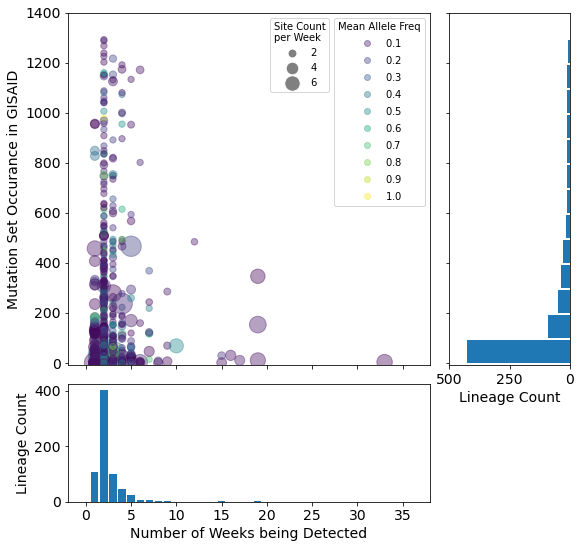

In [53]:
fontsize = 14
fig, axes  = plt.subplots(2, 2, figsize=(9, 9),
                          gridspec_kw={'height_ratios': [3, 1], 'width_ratios': [3, 1], 'hspace':0.08, 'wspace':0.08})

ax = axes[0][0]
scatter = ax.scatter(selected_data['Present Weeks'], selected_data['GISAID Count'],
           s=selected_data['Mean Site Occurance']*40,
           c=selected_data['Mean Allele Freq'],
           cmap='viridis',
           alpha=0.4)

# for idx, row in selected_data.iterrows():
#     if row['Mutation Occurance'] >= 20:
#         ax.annotate(row['Mutation Occurance'], (row['Present Weeks'], row['GISAID Count']),
#                    horizontalalignment='center', verticalalignment='center')

ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('Mutation Set Occurance in GISAID', fontsize=fontsize)
#ax.set_xlabel('Number of Weeks the Mutation Set being Detected', fontsize=fontsize+2)
ax.set_ylim(-10,1400)
ax.set_xlim(-2,38)
ax.set_xticklabels([])

legend1 = ax.legend(*scatter.legend_elements(num=7),
                    loc="upper right", title="Mean Allele Freq")
ax.add_artist(legend1)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='2',
                          markerfacecolor='gray', markersize=np.sqrt(80)),
                   Line2D([0], [0], marker='o', color='w', label='4',
                          markerfacecolor='gray', markersize=np.sqrt(160)),
                   Line2D([0], [0], marker='o', color='w', label='6',
                          markerfacecolor='gray', markersize=np.sqrt(240))]
ax.legend(handles=legend_elements, loc='upper center', title="Site Count\nper Week", bbox_to_anchor=(0.64, 1))
                   
ax = axes[1][0]
bars = ax.bar(week_count, week_count_height, log=False)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
#ax.set_xticklabels([1,10,100])
ax.set_ylabel('Lineage Count', fontsize=fontsize)
ax.set_xlabel('Number of Weeks being Detected', fontsize=fontsize)
ax.set_xlim(-2,38)

ax = axes[0][1]
hbars = ax.barh(occ_list, occ_bar_height, align='edge', height=step*0.9, log=False)
ax.set_ylim(-10,1400)
ax.set_xlim(0,500)
ax.set_yticklabels([])
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.invert_xaxis()
ax.set_xlabel('Lineage Count', fontsize=fontsize)

axes[1][1].set_visible(False)
#fig.tight_layout()

# Viral Load and Population

In [54]:
viral_load_df = pd.read_csv('Wastewater_WWTP_TOTAL_11142022_spline.csv').dropna()

In [55]:
viral_load_df['date']= pd.to_datetime(viral_load_df['date'])

In [56]:
viral_load_df

,WWTP,date,Spline_WW,Spline_WW_se,Spline_WW_cl,Spline_WW_cu,Spline_WW_Percent_10,Spline_WW_Percent_10_cl,Spline_WW_Percent_10_cu
0,z.TOTAL,2020-07-06,13.506285,0.156226,13.230366,13.855270,100.000000,48.702127,205.329843
1,z.TOTAL,2020-07-07,13.517409,0.148465,13.220479,13.814340,102.594628,51.783865,203.261340
2,z.TOTAL,2020-07-08,13.492549,0.140939,13.210672,13.774426,96.886778,50.627610,185.413606
3,z.TOTAL,2020-07-09,13.468253,0.133693,13.200867,13.735638,91.615242,49.497426,169.571494
4,z.TOTAL,2020-07-10,13.444529,0.126777,13.190976,13.698083,86.745052,48.382857,155.524178
...,...,...,...,...,...,...,...,...,...
857,z.TOTAL,2022-11-10,13.510930,0.144944,13.221043,13.800818,101.075440,51.851093,197.030456
858,z.TOTAL,2022-11-11,13.539314,0.156317,13.226681,13.851947,107.901939,52.528600,221.647417
859,z.TOTAL,2022-11-12,13.569124,0.168744,13.231635,13.906612,115.568326,53.131301,251.377957
860,z.TOTAL,2022-11-13,13.600354,0.182121,13.236111,13.964597,124.184967,53.681688,287.284299


In [58]:
population_df = pd.read_csv('population.csv').dropna()

In [59]:
population_df = population_df[['WWTP', 'pop']]

# Target Mutation

## A29039T,G29049A

In [60]:
target_mutation = 'A29039T;G29049A'

In [61]:
selected_data = merged_df[merged_df['Nt Mutations'] == target_mutation].copy()
selected_data = selected_data.merge(population_df, left_on='Site', right_on='WWTP')
date_mean_freqs = selected_data.groupby(['Date'])['Combined Freq'].mean()
date_site_count = selected_data.groupby(['Date'])['Site'].count()
date_pop_sum = selected_data.groupby(['Date'])['pop'].sum()
aa_mut_label = selected_data['AA Mutations'].unique()[0]
selected_data

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq,WWTP,pop
0,2022-01-06,69,A29039T;G29049A,N:K256*;N:R259Q,8,380,0.021053,69,551150
1,2021-09-20,69,A29039T;G29049A,N:K256*;N:R259Q,7,387,0.018088,69,551150
2,2021-09-27,69,A29039T;G29049A,N:K256*;N:R259Q,13,499,0.026052,69,551150
3,2021-10-18,69,A29039T;G29049A,N:K256*;N:R259Q,5,127,0.039370,69,551150
4,2021-11-01,69,A29039T;G29049A,N:K256*;N:R259Q,12,412,0.029126,69,551150
...,...,...,...,...,...,...,...,...,...
193,2021-11-15,111,A29039T;G29049A,N:K256*;N:R259Q,22,903,0.024363,111,20920
194,2021-10-04,KWW,A29039T;G29049A,N:K256*;N:R259Q,25,924,0.027056,KWW,2589
195,2021-11-01,KWW,A29039T;G29049A,N:K256*;N:R259Q,33,935,0.035294,KWW,2589
196,2021-11-08,KWW,A29039T;G29049A,N:K256*;N:R259Q,8,231,0.034632,KWW,2589


In [62]:
sorted(selected_data['Date'].unique())

[numpy.datetime64('2021-08-02T00:00:00.000000000'),
 numpy.datetime64('2021-08-09T00:00:00.000000000'),
 numpy.datetime64('2021-08-16T00:00:00.000000000'),
 numpy.datetime64('2021-08-23T00:00:00.000000000'),
 numpy.datetime64('2021-08-30T00:00:00.000000000'),
 numpy.datetime64('2021-09-06T00:00:00.000000000'),
 numpy.datetime64('2021-09-20T00:00:00.000000000'),
 numpy.datetime64('2021-09-27T00:00:00.000000000'),
 numpy.datetime64('2021-10-04T00:00:00.000000000'),
 numpy.datetime64('2021-10-11T00:00:00.000000000'),
 numpy.datetime64('2021-10-18T00:00:00.000000000'),
 numpy.datetime64('2021-10-25T00:00:00.000000000'),
 numpy.datetime64('2021-11-01T00:00:00.000000000'),
 numpy.datetime64('2021-11-08T00:00:00.000000000'),
 numpy.datetime64('2021-11-15T00:00:00.000000000'),
 numpy.datetime64('2021-11-22T00:00:00.000000000'),
 numpy.datetime64('2021-12-02T00:00:00.000000000'),
 numpy.datetime64('2021-12-10T00:00:00.000000000'),
 numpy.datetime64('2021-12-16T00:00:00.000000000'),
 numpy.datet

In [63]:
date_site_count.sum()

198

In [64]:
date_site_count.shape

(33,)

In [65]:
date_site_count

Date
2021-08-02     7
2021-08-09     3
2021-08-16     2
2021-08-23     2
2021-08-30     8
2021-09-06     1
2021-09-20     7
2021-09-27     4
2021-10-04     8
2021-10-11     5
2021-10-18     8
2021-10-25     4
2021-11-01     5
2021-11-08     6
2021-11-15    16
2021-11-22    13
2021-12-02     9
2021-12-10    11
2021-12-16     7
2021-12-23     4
2021-12-30    12
2022-01-06     8
2022-01-13    10
2022-01-17     5
2022-01-27    10
2022-02-03     7
2022-02-10     3
2022-02-17     1
2022-04-28     1
2022-05-19     1
2022-05-26     7
2022-06-02     2
2022-08-01     1
Name: Site, dtype: int64

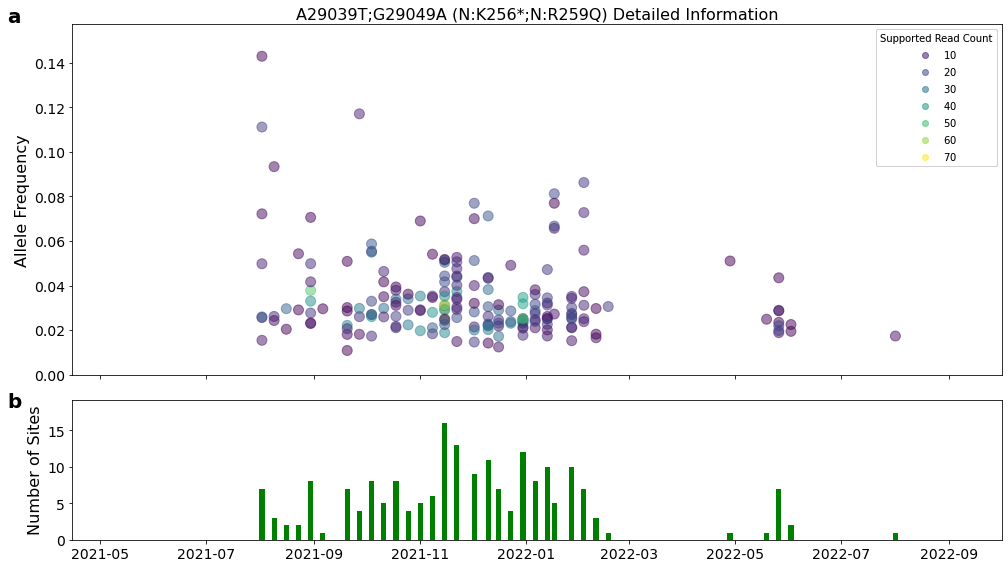

In [83]:
fontsize = 14
fig, axes  = plt.subplots(2, 1, figsize=(14, 8),
                          sharex=True,
                          gridspec_kw={'height_ratios': [2.5, 1]})

ax = axes[0]
scatter = ax.scatter(selected_data['Date'], selected_data['Combined Freq'], 
           s=100,
           c=selected_data['Support DP'], cmap='viridis',
           alpha=0.5)

ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('Allele Frequency', fontsize=fontsize+2)
#ax.set_xlabel('SNV Set Occurancance in GISAID', fontsize=fontsize+2)
ax.set_ylim(0, selected_data['Combined Freq'].max()*1.1)

legend1 = ax.legend(*scatter.legend_elements(num=5),
                    loc="upper right", title="Supported Read Count")
ax.add_artist(legend1)

# ax_twinx = ax.twinx()
# ax.plot(date_mean_freqs.index, date_mean_freqs.values, 
#         ',--r',
#         linewidth=2,
#         alpha=0.75)

ax.set_title(f'{target_mutation} ({aa_mut_label}) Detailed Information', fontsize=fontsize+2)
ax.text(-0.07, 1.05, 'a', transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top')
ax = axes[1]

ax.bar(date_site_count.index, date_site_count.values, width=3, color='g')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('Number of Sites', fontsize=fontsize+2)
#ax.set_xlabel('SNV Set Occurancance in GISAID', fontsize=fontsize+2)
ax.set_ylim(0, date_site_count.values.max()*1.2)
ax.set_xlim([date(2021, 4, 15), date(2022, 10, 1)])

ax.text(-0.07, 1.05, 'b', transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top')
# ax_load = ax.twinx()
# ax_load.plot(viral_load_df['date'], viral_load_df['Spline_WW_Percent_10'], 'k--')

# ax_load.set_xlim([date(2021, 4, 1), date(2022, 10, 1)])
# ax_load.set_ylim([0,1000])
# ax_load.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax_load.set_ylabel('Viral Load', fontsize=fontsize+2)
# ax_load.tick_params(axis='y', which='major', labelsize=fontsize)

fig.tight_layout()

## G28280C,A28281T,T28282A,C28410T

In [84]:
target_mutation = 'G28280C;A28281T;T28282A;C28410T'

In [85]:
selected_data = merged_df[merged_df['Nt Mutations'] == target_mutation].copy()
date_mean_freqs = selected_data.groupby(['Date'])['Combined Freq'].mean()
date_site_count = selected_data.groupby(['Date'])['Site'].count()
aa_mut_label = selected_data['AA Mutations'].unique()[0]
aa_mut_label = "N:D3L;N:P46L"

In [86]:
selected_data

,Date,Site,Nt Mutations,AA Mutations,Support DP,Total DP,Combined Freq
923,2021-03-15,111,G28280C;A28281T;T28282A;C28410T,N:D3H;N:D3V;N:D3E;N:P46L,410,1136,0.360915
959,2021-03-15,203,G28280C;A28281T;T28282A;C28410T,N:D3H;N:D3V;N:D3E;N:P46L,258,647,0.398764
1003,2021-03-15,23,G28280C;A28281T;T28282A;C28410T,N:D3H;N:D3V;N:D3E;N:P46L,284,617,0.460292
1074,2021-03-15,AS,G28280C;A28281T;T28282A;C28410T,N:D3H;N:D3V;N:D3E;N:P46L,632,1242,0.508857
1102,2021-03-15,BW,G28280C;A28281T;T28282A;C28410T,N:D3H;N:D3V;N:D3E;N:P46L,65,219,0.296804
1137,2021-03-15,CD,G28280C;A28281T;T28282A;C28410T,N:D3H;N:D3V;N:D3E;N:P46L,199,442,0.450226
1191,2021-03-15,CR,G28280C;A28281T;T28282A;C28410T,N:D3H;N:D3V;N:D3E;N:P46L,145,271,0.535055
1252,2021-03-15,FC,G28280C;A28281T;T28282A;C28410T,N:D3H;N:D3V;N:D3E;N:P46L,480,975,0.492308
1270,2021-03-15,GR,G28280C;A28281T;T28282A;C28410T,N:D3H;N:D3V;N:D3E;N:P46L,137,300,0.456667
1302,2021-03-15,HO,G28280C;A28281T;T28282A;C28410T,N:D3H;N:D3V;N:D3E;N:P46L,725,1386,0.523088


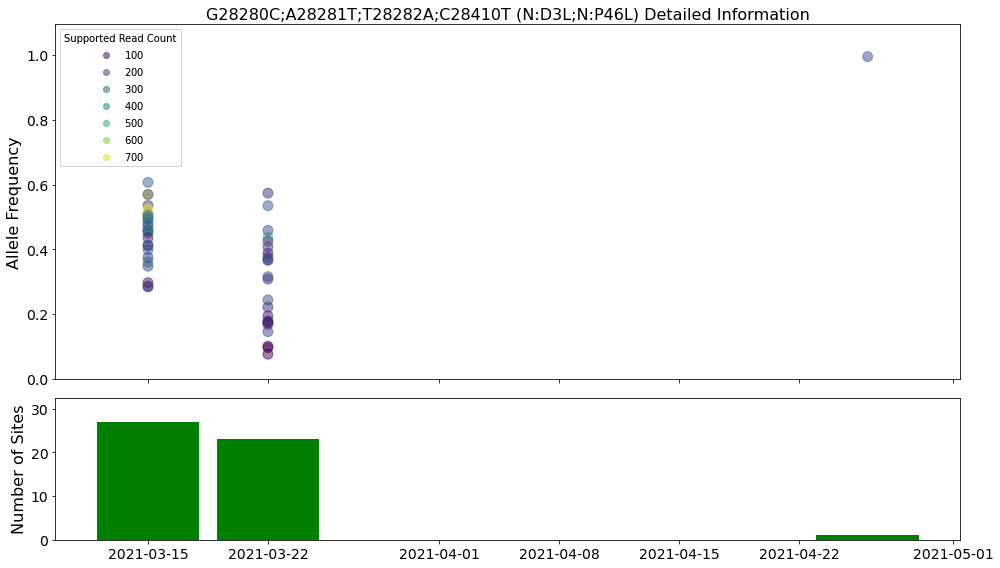

In [87]:
fontsize = 14
fig, axes  = plt.subplots(2, 1, figsize=(14, 8),
                          sharex=True,
                          gridspec_kw={'height_ratios': [2.5, 1]})

ax = axes[0]
scatter = ax.scatter(selected_data['Date'], selected_data['Combined Freq'], 
           s=100,
           c=selected_data['Support DP'], cmap='viridis',
           alpha=0.5)

ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('Allele Frequency', fontsize=fontsize+2)
#ax.set_xlabel('SNV Set Occurancance in GISAID', fontsize=fontsize+2)
ax.set_ylim(0, selected_data['Combined Freq'].max()*1.1)

legend1 = ax.legend(*scatter.legend_elements(num=5),
                    loc="best", title="Supported Read Count")
ax.add_artist(legend1)

# ax_twinx = ax.twinx()
# ax.plot(date_mean_freqs.index, date_mean_freqs.values, 
#         ',--r',
#         linewidth=2,
#         alpha=0.75)

ax.set_title(f'{target_mutation} ({aa_mut_label}) Detailed Information', fontsize=fontsize+2)

ax = axes[1]
ax.bar(date_site_count.index, date_site_count.values, width=6, color='g')
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('Number of Sites', fontsize=fontsize+2)
#ax.set_xlabel('SNV Set Occurancance in GISAID', fontsize=fontsize+2)
ax.set_ylim(0, date_site_count.values.max()*1.2)

fig.tight_layout()

## G19132T,A19137C

In [88]:
target_mutation = 'G19132T;A19137C'

In [89]:
selected_data = merged_df[merged_df['Nt Mutations'] == target_mutation].copy()
date_mean_freqs = selected_data.groupby(['Date'])['Combined Freq'].mean()
date_site_count = selected_data.groupby(['Date'])['Site'].count()
aa_mut_label = selected_data['AA Mutations'].unique()[0]
aa_mut_label

'ORF1b:E1889*;ORF1b:L1890F'

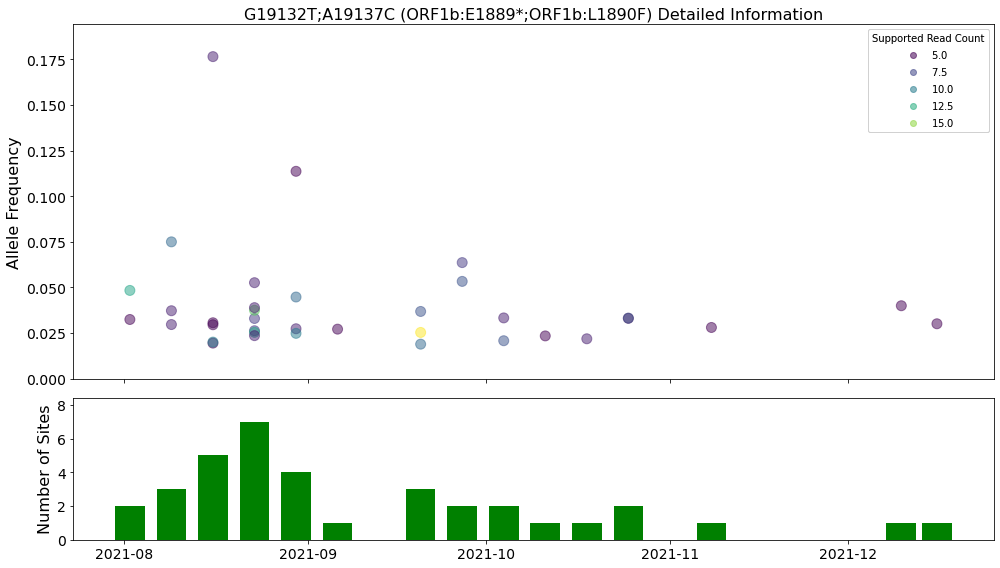

In [90]:
fontsize = 14
fig, axes  = plt.subplots(2, 1, figsize=(14, 8),
                          sharex=True,
                          gridspec_kw={'height_ratios': [2.5, 1]})

ax = axes[0]
scatter = ax.scatter(selected_data['Date'], selected_data['Combined Freq'], 
           s=100,
           c=selected_data['Support DP'], cmap='viridis',
           alpha=0.5)

ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('Allele Frequency', fontsize=fontsize+2)
#ax.set_xlabel('SNV Set Occurancance in GISAID', fontsize=fontsize+2)
ax.set_ylim(0, selected_data['Combined Freq'].max()*1.1)

legend1 = ax.legend(*scatter.legend_elements(num=5),
                    loc="best", title="Supported Read Count")
ax.add_artist(legend1)

# ax_twinx = ax.twinx()
# ax.plot(date_mean_freqs.index, date_mean_freqs.values, 
#         ',--r',
#         linewidth=2,
#         alpha=0.75)

ax.set_title(f'{target_mutation} ({aa_mut_label}) Detailed Information', fontsize=fontsize+2)

ax = axes[1]
ax.bar(date_site_count.index, date_site_count.values, width=5, color='g')
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_ylabel('Number of Sites', fontsize=fontsize+2)
#ax.set_xlabel('SNV Set Occurancance in GISAID', fontsize=fontsize+2)
ax.set_ylim(0, date_site_count.values.max()*1.2)

fig.tight_layout()

# Plot Genome

In [91]:
record = SeqIO.read("../SARS-CoV-2-reference.gb", "genbank")

In [92]:
min_site = 2
max_gisaid_occurance = 0.0001 * gisaid_total_count
print('max_gisaid_occurance:', max_gisaid_occurance)

selected_data = mutation_rarity_df[(mutation_rarity_df['Site'] >= min_site) & (mutation_rarity_df['GISAID Count'] <= max_gisaid_occurance)].copy()
selected_data = selected_data.rename({'Site': 'Mutation Occurance'}, axis=1)
len(selected_data)

max_gisaid_occurance: 1298.8494


716

In [93]:
present_weeks = []
present_sites = []
mean_freqs = []
max_freqs = []
max_durations = []
aa_mutations = []
snp_locations = []

for idx, row in selected_data.iterrows():
    snps = idx.split(";")
    snp_locations.append(int(np.array([int(i[1:-1]) for i in snps]).mean()))
    mutation_df = merged_df[merged_df['Nt Mutations'] == idx]
    present_weeks.append(len(mutation_df['Date'].unique()))    
    present_sites.append(len(mutation_df['Site'].unique()))
    mean_freqs.append(mutation_df['Combined Freq'].mean())
    max_freqs.append(mutation_df['Combined Freq'].max())
    max_durations.append(int((mutation_df['Date'].unique().max()-mutation_df['Date'].unique().min()).astype('timedelta64[D]')/np.timedelta64(1, 'D') + 1))
    aa_mutations.append(mutation_df['AA Mutations'].unique()[0])
    
selected_data['AA Mutation'] = aa_mutations
selected_data['Nt Location'] = snp_locations
selected_data['Present Weeks'] = present_weeks
selected_data['Present Sites'] = present_sites
selected_data['Mean Site Occurance'] = selected_data['Mutation Occurance']/selected_data['Present Weeks']
selected_data['Mean Allele Freq'] = mean_freqs
selected_data['Max Allele Freq'] = max_freqs
selected_data['Max Durations'] = max_durations

selected_data_master = selected_data.sort_values(by=['Mutation Occurance', 'GISAID Count'], ascending=False).copy()
selected_data_master

,Mutation Occurance,GISAID Count,AA Mutation,Nt Location,Present Weeks,Present Sites,Mean Site Occurance,Mean Allele Freq,Max Allele Freq,Max Durations
A29039T;G29049A,198,3,N:K256*;N:R259Q,29044,33,37,6.000000,0.034385,0.142857,365
C6402T;G6456A,133,153,ORF1a:P2046L;ORF1a:C2064Y,6429,19,38,7.000000,0.074002,0.750000,137
A24966T;C25000T,110,10,S:N1135I;S:D1146D,24983,19,34,5.789474,0.047713,0.114754,316
G17122T;A17236G,99,346,ORF1b:A1219S;ORF1b:I1257V,17179,19,34,5.210526,0.021824,0.069530,145
C14676T;G14857T,52,466,ORF1b:P403P;ORF1b:V464F,14766,5,39,10.400000,0.205048,1.000000,57
...,...,...,...,...,...,...,...,...,...,...
T28382C;C28383A,2,0,N:S37P;N:S37*,28382,1,2,2.000000,0.012149,0.014190,1
T28382C;C28383A;C28432T,2,0,N:S37P;N:S37*;N:F53F,28399,1,2,2.000000,0.038820,0.044397,1
T28382C;C28419A;C28432T,2,0,N:S37P;N:T49N;N:F53F,28411,1,2,2.000000,0.051540,0.060000,1
T689A;C690A;T692C;T693C;G881T,2,0,ORF1a:S142T;ORF1a:S142*;ORF1a:F143L;ORF1a:F143...,729,2,1,1.000000,0.484079,0.829268,8


In [94]:
selected_data_master.groupby('Present Weeks').count()

,Mutation Occurance,GISAID Count,AA Mutation,Nt Location,Present Sites,Mean Site Occurance,Mean Allele Freq,Max Allele Freq,Max Durations
Present Weeks,,,,,,,,,
1,109,109,109,109,109,109,109,109,109
2,403,403,403,403,403,403,403,403,403
3,100,100,100,100,100,100,100,100,100
4,47,47,47,47,47,47,47,47,47
5,26,26,26,26,26,26,26,26,26
6,8,8,8,8,8,8,8,8,8
7,8,8,8,8,8,8,8,8,8
8,2,2,2,2,2,2,2,2,2
9,3,3,3,3,3,3,3,3,3


In [95]:
selected_data_master['Present Weeks'].values.max()

33

In [96]:
non_synonyms_exclusive_list = []
for idx, row in selected_data.iterrows():
    aa_mutation_set = row['AA Mutation']
    ns_count = 0
    for aa_muts in aa_mutation_set.split(';'):
        temp = aa_muts.split(":")[-1]
        if temp[0] == temp[-1]:
            ns_count += 1
    if ns_count > 0:
        non_synonyms_exclusive_list.append(False)
    else:
        non_synonyms_exclusive_list.append(True)
        
selected_data['Non-synonyms Only'] = non_synonyms_exclusive_list

In [97]:
selected_data[selected_data['Non-synonyms Only'] == True]

,Mutation Occurance,GISAID Count,AA Mutation,Nt Location,Present Weeks,Present Sites,Mean Site Occurance,Mean Allele Freq,Max Allele Freq,Max Durations,Non-synonyms Only
A11456G;A11600G,2,123,ORF1a:I3731V;ORF1a:I3779V,11528,2,2,1.000000,0.134666,0.252525,15,True
A11456G;T11654C,2,0,ORF1a:I3731V;ORF1a:F3797L,11555,2,2,1.000000,0.079262,0.145833,50,True
A14297T;C14408T,3,1,ORF1b:Y277F;ORF1b:P314L,14352,3,3,1.000000,0.115757,0.260274,190,True
A14395G;C14408T,4,996,ORF1b:T310A;ORF1b:P314L,14401,4,3,1.000000,0.331447,0.666667,78,True
A15301G;G15451A,2,1,ORF1b:K612E;ORF1b:G662S,15376,1,2,2.000000,0.036597,0.043478,1,True
...,...,...,...,...,...,...,...,...,...,...,...
T670G;G714A,2,393,ORF1a:S135R;ORF1a:G150D,692,2,2,1.000000,0.193987,0.209402,120,True
T670G;T693C,4,84,ORF1a:S135R;ORF1a:F143S,681,3,4,1.333333,0.117329,0.157143,141,True
T689A;C690A;T692C;T693C,4,0,ORF1a:S142T;ORF1a:S142*;ORF1a:F143L;ORF1a:F143S,691,4,2,1.000000,0.424871,0.588889,92,True
T689A;C690A;T692C;T693C;G881T,2,0,ORF1a:S142T;ORF1a:S142*;ORF1a:F143L;ORF1a:F143...,729,2,1,1.000000,0.484079,0.829268,8,True


In [98]:
gene_list = []
s_gene_count = 0
n_gene_count = 0
orf1a_count = 0
orf1b_count = 0

for idx, row in selected_data.iterrows():
    aa_muts = row['AA Mutation'].split(';')
    gene_set = set()
    for aa_mut in aa_muts:
        gene = aa_mut.split(':')[0]
        gene_set.add(gene)
        
    gene_list.append(";".join(list(gene_set)))
    
    if 'S' in gene_set:
        s_gene_count += 1
    if 'N' in gene_set:
        n_gene_count += 1
    if 'ORF1a' in gene_set:
        orf1a_count += 1
    if 'ORF1b' in gene_set:
        orf1b_count += 1      
    
selected_data['Gene'] = gene_list

In [99]:
s_gene_count, s_gene_count/selected_data.shape[0]

(146, 0.20391061452513967)

In [100]:
n_gene_count, n_gene_count/selected_data.shape[0]

(200, 0.27932960893854747)

In [101]:
orf1a_count, orf1b_count

(155, 115)

In [102]:
selected_data[selected_data['Mean Allele Freq']<0.5].shape[0], selected_data[selected_data['Mean Allele Freq']<0.5].shape[0]/selected_data.shape[0]

(660, 0.9217877094972067)

In [103]:
bin_width = 400

selected_data['Bin Index'] = selected_data['Nt Location']/bin_width
selected_data['Bin Index'] = selected_data['Bin Index'].astype(int)
selected_data['Bin Index'] = selected_data['Bin Index'] * bin_width + bin_width/2

hist_df = pd.DataFrame(selected_data.groupby(['Bin Index']).count())

bar_x = hist_df.index.to_list()
bar_y1 = hist_df['AA Mutation'].values

hist_df = pd.DataFrame(selected_data.groupby(['Bin Index'])['Non-synonyms Only'].sum())
bar_y2 = hist_df['Non-synonyms Only'].values

In [104]:
bar_y2.sum()

369

In [105]:
bar_y1.sum()

716

In [106]:
def add_colorbar(mappable):
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.get_yaxis().labelpad = 5
    cbar.ax.set_ylabel('Rarity in GISAID', rotation=90, fontsize=fontsize)
    plt.sca(last_axes)
    return cbar

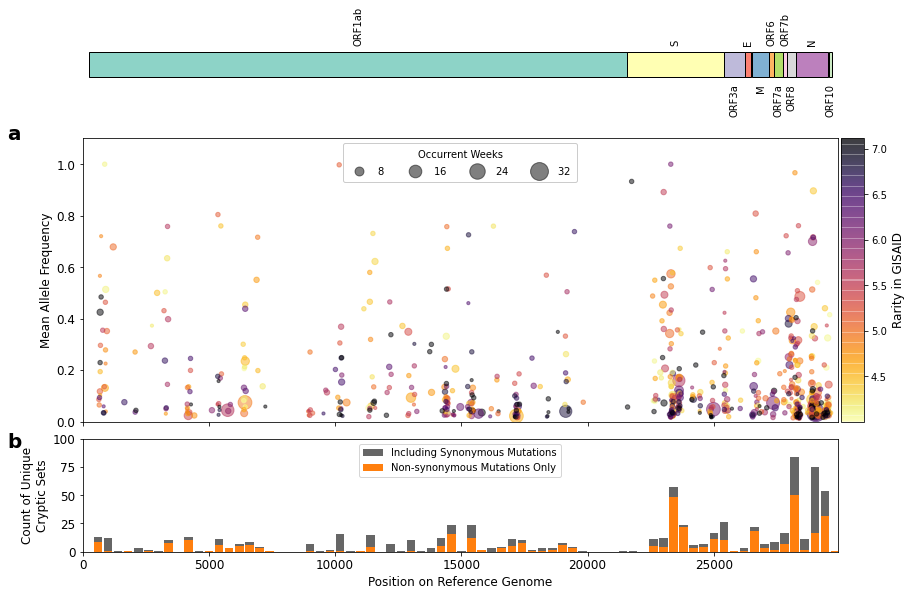

In [109]:
fig, axes  = plt.subplots(3, 1, figsize=(14, 10),
                          sharex=True,
                          gridspec_kw={'height_ratios': [1, 2.5, 1], 'hspace':0.1})

fontsize = 12
alpha = 0.5

cmap = mpl.cm.inferno_r

ax = axes[1]

rarity = -np.log10((selected_data_master['GISAID Count'].values+1)/gisaid_total_count)
main_plot = ax.scatter(x=selected_data_master['Nt Location'].values, 
                       y=selected_data_master['Mean Allele Freq'].values, 
                       c=rarity, 
                       s=selected_data_master['Present Weeks'].values*10,
                       cmap=cmap,
                       alpha=alpha)

ax.set_xlim(0, 29903+1)
#ax.set_xticks(np.arange(0, 29903+1, 5000))

ax.set_ylim(0,1.1)
ax.set_yticks(np.arange(0, 11, 2)/10)
ax.set_ylabel('Mean Allele Frequency', fontsize=fontsize)

ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)

add_colorbar(main_plot)

handles, labels = main_plot.legend_elements(prop="sizes", alpha=alpha, num=4, func = lambda x: x/10)
legend = ax.legend(handles, labels, loc="upper center", title="Occurrent Weeks", ncol=4, framealpha=1, borderpad=0.6, bbox_to_anchor=(0.5,1))
legend.get_frame().set_facecolor('none')

ax.text(-0.1, 1.05, 'a', transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top')

ax = axes[0]
colors = plt.get_cmap('Set3').colors

gene_label_h = 0.5
gene_label_y = -gene_label_h/2
label_top = gene_label_h/2*1.5
counter = 0

for seq_feature in record.features:
    if seq_feature.type == 'gene':
        
        gene_name = seq_feature.qualifiers['gene'][0]
        
        rectangle = Rectangle((seq_feature.location.start, gene_label_y), seq_feature.location.end-seq_feature.location.start, gene_label_h,
                              fill=True,
                              facecolor=colors[counter],
                              edgecolor='black')
        ax.add_patch(rectangle)
        
        if counter != 0:
            rx, ry = rectangle.get_xy()
            cx = rx + rectangle.get_width()/2.0
            cy = ry + rectangle.get_height()/2.0 + label_top
            if label_top > 0:
                va = 'top'
            else:
                va = 'bottom'
            ax.annotate(gene_name, (cx, cy), color='black', weight='normal', fontsize=fontsize-2, ha='center', va=va, rotation=90)
        else:
            rx, ry = rectangle.get_xy()
            cx = rx + rectangle.get_width()/2.0
            cy = ry + rectangle.get_height()/2.0 - label_top
            ax.annotate(gene_name, (cx, cy), color='black', weight='normal', fontsize=fontsize-2, ha='center', va='bottom', rotation=90)
        
        counter += 1
        label_top = label_top * -1
        

ax.set_ylim(-label_top*3,label_top*3)
comb_pos = -2.5

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

ax.axis('off')
cax.axis('off')

ax = axes[2]

ax.bar(bar_x, bar_y1, width=bin_width*0.85, color="black", alpha=0.6, label='Including Synonymous Mutations')
ax.bar(bar_x, bar_y2, width=bin_width*0.85, color="C1", alpha=1, label='Non-synonymous Mutations Only')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

#ax.axis('off')
cax.axis('off')
ax.set_xticks(np.arange(0, 29903+1, 5000))
ax.set_xlabel('Position on Reference Genome', fontsize=fontsize)
ax.set_ylim(0,100)
ax.set_ylabel('Count of Unique\nCryptic Sets', fontsize=fontsize)

ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)

ax.legend(loc='upper center')
ax.text(-0.1, 1.05, 'b', transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top')
fig.show()

In [110]:
bar_y2.sum()

369

# Plot Time

In [111]:
%%time
with open('lineage_data.full.json', 'r') as json_f:
    lineage_json = json.loads(json_f.read())
metadata_f = "/home/Users/ns58/MSA-01102023/metadata.tsv"
metadata = load_metadata(metadata_f)

CPU times: user 3min 34s, sys: 57.9 s, total: 4min 32s
Wall time: 4min 32s


In [112]:
voc_dict = dict()
for item in lineage_json:
    if "B.1.617.2" in lineage_json[item]['Description'] or item == "B.1.617.2":
        voc_dict[item] = 'Delta'
    if "Alias of B.1.1.529" in lineage_json[item]['Description'] or item == "B.1.1.529":
        voc_dict[item] = 'Omicron'
    if "Alias of B.1.1.529.2" in lineage_json[item]['Description'] or item == "BA.2": 
        voc_dict[item] = 'BA.2'
    if "Alias of B.1.1.529.5" in lineage_json[item]['Description'] or item == "BA.5":
        voc_dict[item] = 'BA.5'    

In [113]:
tx_meta = metadata[metadata['Location'] == 'North America / USA / Texas']

In [114]:
tx_meta = tx_meta.reset_index()

In [115]:
tx_meta['Week'] = tx_meta['Collection date'].dt.to_period('W').dt.start_time

In [116]:
voc_list = []
for idx, row in tx_meta.iterrows():
    pango = row['Pango lineage']
    try:
        voc_list.append(voc_dict[pango])
    except KeyError:
        voc_list.append('Other')

In [117]:
tx_meta['VOC'] = voc_list

In [118]:
tx_meta

,Collection date,Pango lineage,Accession ID,Location,Week,VOC
0,2022-03-03,BA.1.1,EPI_ISL_11350659,North America / USA / Texas,2022-02-28,Omicron
1,2021-09-13,AY.100,EPI_ISL_5317623,North America / USA / Texas,2021-09-13,Delta
2,2021-09-15,AY.26,EPI_ISL_5317626,North America / USA / Texas,2021-09-13,Delta
3,2021-09-24,AY.25.1,EPI_ISL_5320586,North America / USA / Texas,2021-09-20,Delta
4,2021-09-24,AY.44,EPI_ISL_5320589,North America / USA / Texas,2021-09-20,Delta
...,...,...,...,...,...,...
142538,2021-07-24,AY.3,EPI_ISL_3687447,North America / USA / Texas,2021-07-19,Delta
142539,2021-07-24,AY.105,EPI_ISL_3687446,North America / USA / Texas,2021-07-19,Delta
142540,2021-07-22,AY.100,EPI_ISL_3687440,North America / USA / Texas,2021-07-19,Delta
142541,2021-07-24,AY.103,EPI_ISL_3687449,North America / USA / Texas,2021-07-19,Delta


In [119]:
first_occ_df = selected_data.merge(merged_df.sort_values('Date')[['Date', 'Nt Mutations']].drop_duplicates('Nt Mutations'), left_index=True, right_on='Nt Mutations').set_index('Nt Mutations')
first_occ_df

,Mutation Occurance,GISAID Count,AA Mutation,Nt Location,Present Weeks,Present Sites,Mean Site Occurance,Mean Allele Freq,Max Allele Freq,Max Durations,Non-synonyms Only,Gene,Bin Index,Date
Nt Mutations,,,,,,,,,,,,,,
A1003G;C913T,5,95,ORF1a:E246E;ORF1a:S216S,958,3,5,1.666667,0.351560,1.000000,29,False,ORF1a,1000.0,2021-03-15
A10195G;C10252T,9,14,ORF1a:E3310E;ORF1a:F3329F,10223,2,9,4.500000,0.050277,0.149755,8,False,ORF1a,10200.0,2021-03-15
A10195G;C10277T,3,33,ORF1a:E3310E;ORF1a:L3338F,10236,3,3,1.000000,0.368590,1.000000,50,False,ORF1a,10200.0,2021-03-15
A10195G;C10319T,7,3,ORF1a:E3310E;ORF1a:L3352F,10257,4,7,1.750000,0.153575,0.993521,43,False,ORF1a,10200.0,2021-03-15
A10195G;C10332T,2,12,ORF1a:E3310E;ORF1a:T3356I,10263,2,2,1.000000,0.180665,0.312150,29,False,ORF1a,10200.0,2021-03-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T7233G;A7234T;G7235T,2,0,ORF1a:L2323*;ORF1a:L2323F;ORF1a:V2324F,7234,1,2,2.000000,0.058347,0.075758,1,True,ORF1a,7400.0,2021-12-30
T847A;C913T,10,293,ORF1a:D194E;ORF1a:S216S,880,5,9,2.000000,0.130813,0.404762,71,False,ORF1a,1000.0,2021-03-01
T886C;C913T,2,71,ORF1a:R207R;ORF1a:S216S,899,2,2,1.000000,0.463548,0.485772,15,False,ORF1a,1000.0,2021-05-10


## Load Coverage Data

In [120]:
coverage_df = pd.read_csv('/home/Users/yl181/wastewater/quarc_figures/coverage_df.csv', index_col=0)

In [121]:
coverage_df['Date'] = pd.to_datetime(coverage_df['Date'])

In [122]:
min_coverage = coverage_df[coverage_df['Date'] >= pd.Timestamp('2021-05-01')]['Breadth_Coverage'].min()
max_coverage = coverage_df[coverage_df['Date'] >= pd.Timestamp('2021-05-01')]['Breadth_Coverage'].max()

In [123]:
coverage_df['Width'] = (coverage_df['Breadth_Coverage']-min_coverage)/(max_coverage-min_coverage)*0.9 + 0.1

In [124]:
coverage_df[coverage_df['Date'] >= pd.Timestamp('2021-05-01')]['Width'].max()

1.0

## Plot

In [125]:
time_df = pd.DataFrame(first_occ_df.groupby(['Date'])['AA Mutation'].count())

bar_x = time_df.index.to_list()
bar_y1 = time_df['AA Mutation'].values
time_min = time_df.index.min()
time_max = time_df.index.max()

time_df = pd.DataFrame(first_occ_df.groupby(['Date'])['Non-synonyms Only'].sum())
time_df = time_df.merge(coverage_df, left_index=True, right_on=['Date'])
bar_y2 = time_df['Non-synonyms Only'].values
bar_w = time_df['Width'].values

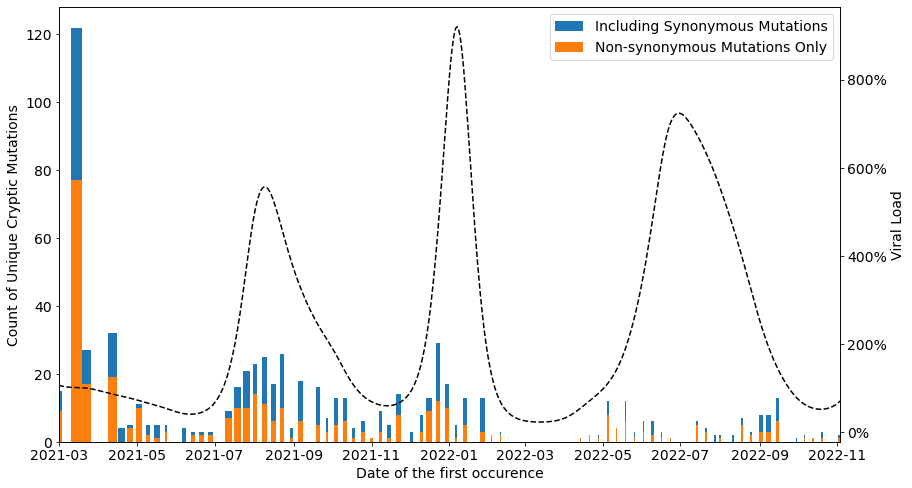

In [126]:
fontsize = 14
fig, ax  = plt.subplots(1, 1, figsize=(14, 8))

ax.bar(bar_x, bar_y1, width=6*bar_w, label='Including Synonymous Mutations')
ax.bar(bar_x, bar_y2, width=6*bar_w, label='Non-synonymous Mutations Only')

ax.set_xlim(time_min, time_max)
#ax.set_ylim(0,70)
ax_load = ax.twinx()
ax_load.plot(viral_load_df['date'], viral_load_df['Spline_WW_Percent_10'], 'k--')

ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xlabel('Date of the first occurence', fontsize=fontsize)
ax.set_ylabel('Count of Unique Cryptic Mutations', fontsize=fontsize)

ax_load.yaxis.set_major_formatter(mtick.PercentFormatter())
ax_load.set_ylabel('Viral Load', fontsize=fontsize)
ax_load.tick_params(axis='y', which='major', labelsize=fontsize)

ax.legend(fontsize=fontsize)

Text(-0.12, 1.05, 'b')

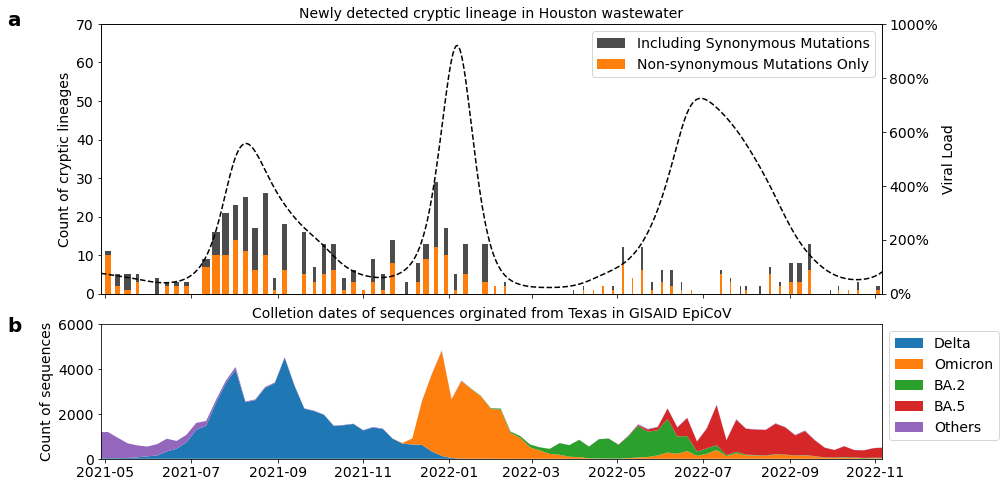

In [157]:
fontsize = 14
fig, axes  = plt.subplots(2, 1, figsize=(14, 8), sharex=True,
                         gridspec_kw={'height_ratios': [2, 1], 'hspace':0.15})

ax = axes[0]

ax.bar(bar_x, bar_y1, width=6*bar_w, label='Including Synonymous Mutations', color="black", alpha=0.7)
ax.bar(bar_x, bar_y2, width=6*bar_w, label='Non-synonymous Mutations Only', color='C1')

ax.set_xlim(pd.Timestamp('2021-05-01')-timedelta(days=3), time_max+timedelta(days=3))
ax.set_ylim(0,70)
ax_load = ax.twinx()
ax_load.plot(viral_load_df['date'], viral_load_df['Spline_WW_Percent_10'], 'k--')
ax_load.set_ylim(0,1000)

ax.tick_params(axis='both', which='major', labelsize=fontsize)

ax.set_ylabel('Count of cryptic lineages', fontsize=fontsize)
ax_load.yaxis.set_major_formatter(mtick.PercentFormatter())
ax_load.set_ylabel('Viral Load', fontsize=fontsize)
ax_load.tick_params(axis='y', which='major', labelsize=fontsize)
ax.legend(fontsize=fontsize)
ax.text(-0.12, 1.05, 'a', transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top')

ax.set_title('Newly detected cryptic lineage in Houston wastewater', fontsize=fontsize)

ax = axes[1]

voc_df = pd.pivot_table(tx_meta, values='Accession ID', index='Week', columns=['VOC'], aggfunc='count', fill_value=0)

#voc_df = pd.pivot_table(tx_meta, values='Accession ID', index='Collection date', columns=['VOC'], aggfunc='count', fill_value=0)
ax.stackplot(voc_df.index, voc_df['Delta'], voc_df['Omicron'], voc_df['BA.2'], voc_df['BA.5'], voc_df['Other'],
            labels = ['Delta', 'Omicron', 'BA.2', 'BA.5', 'Others'])

# ax.plot(voc_df.index, , label='')
# ax.plot(voc_df.index, , label='BA.2')
# ax.plot(voc_df.index, , label='BA.5')
# ax.plot(voc_df.index, , label='Omicron')
# ax.plot(voc_df.index, , label='Others')

ax.legend()
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_title('Colletion dates of sequences orginated from Texas in GISAID EpiCoV', fontsize=fontsize)
#ax.set_xlabel('Date', fontsize=fontsize)

ax.set_ylabel('Count of sequences', fontsize=fontsize)
ax.set_ylim(0,6000)
ax.legend(fontsize=fontsize, ncol=1, loc=2, bbox_to_anchor=(1,1))
ax.text(-0.12, 1.05, 'b', transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top')

# dN/dS Calculation

In [290]:
# Check Codon Start
codon_start_from_1 = True
for seq_feature in record.features:
    if seq_feature.type == 'CDS':
        if seq_feature.qualifiers['codon_start'] != ['1']:
            print(seq_feature.qualifiers['gene'], seq_feature.qualifiers['codon_start'])
            codon_start_from_1 = False
if codon_start_from_1:
    print('All CDS have codon start from 1.')

All CDS have codon start from 1.


In [291]:
protein_coding_lookup = OrderedDict()
for seq_feature in record.features:
    if seq_feature.type == 'gene':
        gene_name = seq_feature.qualifiers['gene'][0]
        if gene_name == 'ORF1ab':
            protein_coding_lookup['ORF1a'] = (265, 13468)
            protein_coding_lookup['ORF1b'] = (13467, 21555)
        else:
            gene_start = int(seq_feature.location.start)
            gene_end = int(seq_feature.location.end)
            protein_coding_lookup[gene_name] = (gene_start, gene_end)
protein_coding_lookup

OrderedDict([('ORF1a', (265, 13468)),
             ('ORF1b', (13467, 21555)),
             ('S', (21562, 25384)),
             ('ORF3a', (25392, 26220)),
             ('E', (26244, 26472)),
             ('M', (26522, 27191)),
             ('ORF6', (27201, 27387)),
             ('ORF7a', (27393, 27759)),
             ('ORF7b', (27755, 27887)),
             ('ORF8', (27893, 28259)),
             ('N', (28273, 29533)),
             ('ORF10', (29557, 29674))])

In [292]:
nucleotides = {'A', 'C', 'T', 'G'}
expected_n_lookup = dict()

In [293]:
def expected_n(query_nt3, expected_n_lookup):
    def calculate_n(query_seq):
        n_sites = 0
        for i in range(3):
            for snp in nucleotides:
                if i-1 >= 0:
                    mutated_seq = query_seq[0:i] + snp + query_seq[i+1:]
                else:
                    mutated_seq = snp + query_seq[i+1:]
                if Seq(query_seq).translate() != Seq(mutated_seq).translate():
                    n_sites += 1
        return n_sites/3
    
    if not query_nt3 in expected_n_lookup:
        expected_n_lookup[query_nt3] = calculate_n(query_nt3)
        
    return expected_n_lookup[query_nt3]

In [294]:
def range_intersect(query_r, gene_r):
    start = max(query_r[0], gene_r[0])
    end = min(query_r[1], gene_r[1])
    #print(start, end)
    if start < end:
        if start == query_r[0]:
            offset = 3-(query_r[0] - gene_r[0])%3
            start = start + offset   
        if end == query_r[1]:
            offset = 3-(end - start)%3
            end = end + offset
        return start, end

In [295]:
def expected_n_s_sum(query_seq, expected_n_lookup):
    sum_n = 0
    if len(query_seq) % 3 == 0:
        for i in range(0, len(query_seq), 3):
            sum_n += expected_n(query_seq[i:i+3], expected_n_lookup)
    else:
        print('Error: Sequence length is not a multication of 3.')
    
    sum_s = len(query_seq) - sum_n
    
    return sum_n, sum_s

In [296]:
def calc_n_s_for_bin(query_range):
    gene_hits = set()
    for coding_region in protein_coding_lookup:
        if query_range[1] <= protein_coding_lookup[coding_region][1] and query_range[1] >=  protein_coding_lookup[coding_region][0]:
            gene_hits.add(coding_region)
            break
    for coding_region in reversed(protein_coding_lookup):
        if query_range[0] >= protein_coding_lookup[coding_region][0] and query_range[0] <= protein_coding_lookup[coding_region][1]:
            gene_hits.add(coding_region)
            break
            
    #print(query_range, gene_hits)
    n = 0
    s = 0
    for gene in gene_hits:
        trimmed_start, trimmed_end = range_intersect(query_range, protein_coding_lookup[gene])
        temp_n, temp_s = expected_n_s_sum(record.seq[trimmed_start:trimmed_end], expected_n_lookup)
        n += temp_n
        s += temp_s
    
    return n, s

In [297]:
def calc_dnds(n, s, observed_n, observed_s):
    p_n = (observed_n)/n
    p_s = (observed_s)/s
    dn = -3/4 *np.log(1-(4*p_n/3))
    ds = -3/4 *np.log(1-(4*p_s/3))
    
    # if dn == 0:
    #     return 0
    # if ds == 0:
    #     return 5
    
    return dn/ds

In [298]:
# n, s = expected_n_s_sum('ATGAAACCCGGGTTTTAA', expected_n_lookup)
# observed_n = 2
# observed_s = 2
# calc_dnds(n, s, observed_n, observed_s)

In [299]:
# calc_n_s_for_bin((13400, 13800))

## Unique SNPs

In [300]:
selected_data = selected_data_master.copy()
selected_data

,Mutation Occurance,GISAID Count,AA Mutation,Nt Location,Present Weeks,Present Sites,Mean Site Occurance,Mean Allele Freq,Max Allele Freq,Max Durations
A29039T;G29049A,198,3,N:K256*;N:R259Q,29044,33,37,6.000000,0.034385,0.142857,365
C6402T;G6456A,133,153,ORF1a:P2046L;ORF1a:C2064Y,6429,19,38,7.000000,0.074002,0.750000,137
A24966T;C25000T,110,10,S:N1135I;S:D1146D,24983,19,34,5.789474,0.047713,0.114754,316
G17122T;A17236G,99,346,ORF1b:A1219S;ORF1b:I1257V,17179,19,34,5.210526,0.021824,0.069530,145
C14676T;G14857T,52,466,ORF1b:P403P;ORF1b:V464F,14766,5,39,10.400000,0.205048,1.000000,57
...,...,...,...,...,...,...,...,...,...,...
T28382C;C28383A,2,0,N:S37P;N:S37*,28382,1,2,2.000000,0.012149,0.014190,1
T28382C;C28383A;C28432T,2,0,N:S37P;N:S37*;N:F53F,28399,1,2,2.000000,0.038820,0.044397,1
T28382C;C28419A;C28432T,2,0,N:S37P;N:T49N;N:F53F,28411,1,2,2.000000,0.051540,0.060000,1
T689A;C690A;T692C;T693C;G881T,2,0,ORF1a:S142T;ORF1a:S142*;ORF1a:F143L;ORF1a:F143...,729,2,1,1.000000,0.484079,0.829268,8


In [301]:
def is_nonsynonymous(aa_mut):
    temp_str = aa_mut.split(":")[1]
    return temp_str[0] != temp_str[-1]

In [302]:
unique_snp_list = []
for idx, row in selected_data.iterrows():
    nt_mut_list = idx.split(";")
    aa_mut_list = row['AA Mutation'].split(";")
    
    for i, nt_mut in enumerate(nt_mut_list):
        loc = int(nt_mut[1:-1])
        unique_snp_list.append({'Nt Mut': nt_mut, 'Location': loc, 'Is Nonsynonymous': is_nonsynonymous(aa_mut_list[i])})

In [303]:
unique_snp_df = pd.DataFrame(unique_snp_list).set_index('Nt Mut').drop_duplicates()

In [304]:
bin_width = 1000

unique_snp_df['Bin Index'] = unique_snp_df['Location']/bin_width
unique_snp_df['Bin Index'] = unique_snp_df['Bin Index'].astype(int)
unique_snp_df['Bin Index'] = unique_snp_df['Bin Index'] * bin_width + bin_width/2

In [305]:
unique_snp_df

,Location,Is Nonsynonymous,Bin Index
Nt Mut,,,
A29039T,29039,True,29500.0
G29049A,29049,True,29500.0
C6402T,6402,True,6500.0
G6456A,6456,True,6500.0
A24966T,24966,True,24500.0
...,...,...,...
C28419A,28419,True,28500.0
G881T,881,True,500.0
T7233G,7233,True,7500.0


In [306]:
hist_df1 = pd.DataFrame(unique_snp_df.groupby(['Bin Index']).count())

bar_x = hist_df1.index.to_list()
bar_y1 = hist_df1['Location'].values

hist_df2 = pd.DataFrame(unique_snp_df.groupby(['Bin Index'])['Is Nonsynonymous'].sum())
bar_y2 = hist_df2['Is Nonsynonymous'].values

In [307]:
hist_df2['Total SNPs'] = hist_df1['Location']

## Sliding Window dN/dS

In [89]:
import warnings
warnings.filterwarnings("ignore")

In [90]:
window_size = 600

plot_x = np.arange(0, len(record.seq), 50)
dnds_list = []

for idx in plot_x:
    start = int(idx - window_size/2)
    end = int(idx + window_size/2)
    seq = record.seq[start:end]
    n, s = calc_n_s_for_bin((start, end))
    temp_df = unique_snp_df[(unique_snp_df['Location'] >= start) & (unique_snp_df['Location'] < end)]
    observed_n = temp_df['Is Nonsynonymous'].sum()
    observed_s = temp_df.shape[0] - observed_n
    dnds = calc_dnds(n, s, observed_n, observed_s)
    dnds_list.append(dnds)
    

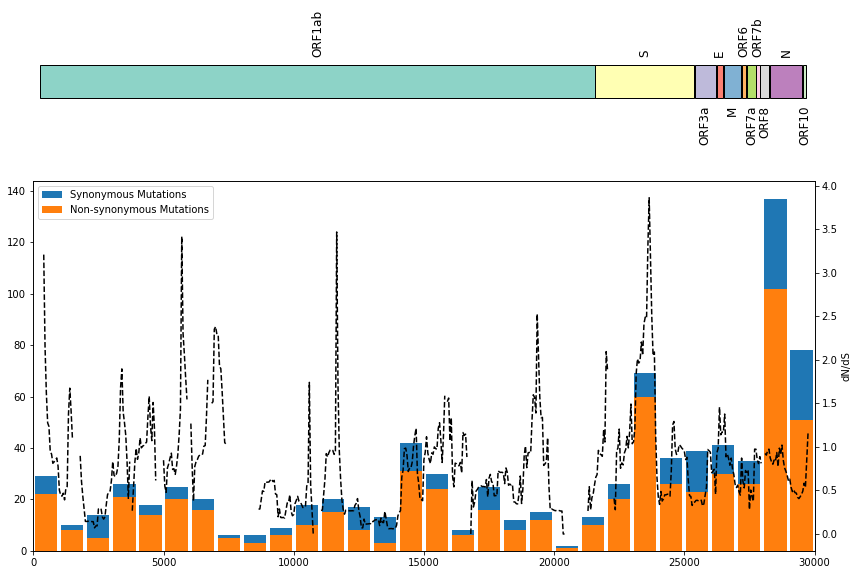

In [91]:
fig, axes  = plt.subplots(2, 1, figsize=(14, 10),
                          sharex=True,
                          gridspec_kw={'height_ratios': [1, 2.5], 'hspace':0.1})

ax = axes[0]
colors = plt.get_cmap('Set3').colors

gene_label_h = 0.5
gene_label_y = -gene_label_h/2
label_top = gene_label_h/2*1.5
counter = 0

for seq_feature in record.features:
    if seq_feature.type == 'gene':
        
        gene_name = seq_feature.qualifiers['gene'][0]
        
        rectangle = Rectangle((seq_feature.location.start, gene_label_y), seq_feature.location.end-seq_feature.location.start, gene_label_h,
                              fill=True,
                              facecolor=colors[counter],
                              edgecolor='black')
        ax.add_patch(rectangle)
        
        if counter != 0:
            rx, ry = rectangle.get_xy()
            cx = rx + rectangle.get_width()/2.0
            cy = ry + rectangle.get_height()/2.0 + label_top
            if label_top > 0:
                va = 'top'
            else:
                va = 'bottom'
            ax.annotate(gene_name, (cx, cy), color='black', weight='normal', fontsize=fontsize-2, ha='center', va=va, rotation=90)
        else:
            rx, ry = rectangle.get_xy()
            cx = rx + rectangle.get_width()/2.0
            cy = ry + rectangle.get_height()/2.0 - label_top
            ax.annotate(gene_name, (cx, cy), color='black', weight='normal', fontsize=fontsize-2, ha='center', va='bottom', rotation=90)
        
        counter += 1
        label_top = label_top * -1
        

ax.set_ylim(-label_top*3,label_top*3)
comb_pos = -2.5
ax.axis('off')

ax = axes[1]

ax.bar(bar_x, bar_y1, width=bin_width*0.85, label='Synonymous Mutations')
ax.bar(bar_x, bar_y2, width=bin_width*0.85, label='Non-synonymous Mutations')

ax_twinx = ax.twinx()
#ax_twinx.plot(bar_x, hist_df2['dN/dS'].values, '.--')

ax_twinx.plot(plot_x, dnds_list, 'k--')
#ax_twinx.set_ylim(0, 5)

ax_twinx.set_ylabel("dN/dS")

ax.set_xlim(0,30000)
ax.legend()

## Fixed Bin dN/dS

In [308]:
dnds_list = []
for idx, row in hist_df2.iterrows():
    start = int(idx - bin_width/2)
    end = int(idx + bin_width/2)
    seq = record.seq[start:end]
    n, s = calc_n_s_for_bin((start, end))
    observed_n = row['Is Nonsynonymous']
    observed_s = row['Total SNPs'] - observed_n
    dnds = calc_dnds(n, s, observed_n, observed_s)
    dnds_list.append(dnds)
    
hist_df2['dN/dS'] = dnds_list

In [309]:
hist_df2['dN/dS'].values

array([0.92433312, 0.71028411, 0.13987759, 1.30711953, 1.06341443,
       1.054899  , 1.1138068 , 1.36189638, 0.28552256, 0.57031208,
       0.31796226, 0.82203749, 0.24534788, 0.07892677, 0.72476414,
       1.09014624, 0.84976033, 0.51193757, 0.55191153, 1.06746828,
       0.41054894, 0.91261148, 2.02573436, 0.75304273, 0.36912342,
       0.86036127, 0.81611242, 0.84895801, 0.45102046])

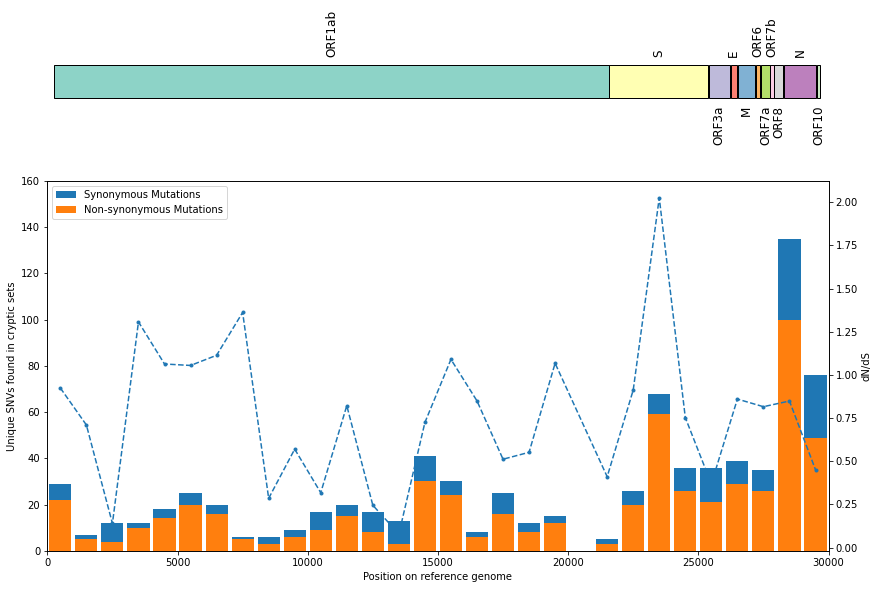

In [310]:
fig, axes  = plt.subplots(2, 1, figsize=(14, 10),
                          sharex=True,
                          gridspec_kw={'height_ratios': [1, 2.5], 'hspace':0.1})

ax = axes[0]
colors = plt.get_cmap('Set3').colors

gene_label_h = 0.5
gene_label_y = -gene_label_h/2
label_top = gene_label_h/2*1.5
counter = 0

for seq_feature in record.features:
    if seq_feature.type == 'gene':
        
        gene_name = seq_feature.qualifiers['gene'][0]
        
        rectangle = Rectangle((seq_feature.location.start, gene_label_y), seq_feature.location.end-seq_feature.location.start, gene_label_h,
                              fill=True,
                              facecolor=colors[counter],
                              edgecolor='black')
        ax.add_patch(rectangle)
        
        if counter != 0:
            rx, ry = rectangle.get_xy()
            cx = rx + rectangle.get_width()/2.0
            cy = ry + rectangle.get_height()/2.0 + label_top
            if label_top > 0:
                va = 'top'
            else:
                va = 'bottom'
            ax.annotate(gene_name, (cx, cy), color='black', weight='normal', fontsize=fontsize-2, ha='center', va=va, rotation=90)
        else:
            rx, ry = rectangle.get_xy()
            cx = rx + rectangle.get_width()/2.0
            cy = ry + rectangle.get_height()/2.0 - label_top
            ax.annotate(gene_name, (cx, cy), color='black', weight='normal', fontsize=fontsize-2, ha='center', va='bottom', rotation=90)
        
        counter += 1
        label_top = label_top * -1
        

ax.set_ylim(-label_top*3,label_top*3)
comb_pos = -2.5
ax.axis('off')

ax = axes[1]

ax.bar(bar_x, bar_y1, width=bin_width*0.85, label='Synonymous Mutations')
ax.bar(bar_x, bar_y2, width=bin_width*0.85, label='Non-synonymous Mutations')

ax.set_ylim(0,160)
ax.set_ylabel('Unique SNVs found in cryptic sets')
ax.set_xlabel('Position on reference genome')

ax_twinx = ax.twinx()
ax_twinx.plot(bar_x, hist_df2['dN/dS'].values, '.--')

#ax_twinx.plot(plot_x, dnds_list, 'k--')
#ax_twinx.set_ylim(0, 5)

ax_twinx.set_ylabel("dN/dS")

ax.set_xlim(0,30000)
ax.legend(loc='upper left')